In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import pandas as pd
import numpy as np
import random 
import seaborn as sns
from math import log2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# calling helper funtions
import data_prepare as dp
from helper import data_viz as dviz
import data_split as ds
from helper import prediction as pred

In [2]:
# more than two features 
#df = pd.read_csv("data/014f2liris.csv")
#df = pd.read_csv("data/024f2liris.csv")
#df = pd.read_csv("data/124f2liris.csv")

# more than two classes

# perfect two class two features
#df = pd.read_csv("data/circle.csv")
df = pd.read_csv("data/weight-height.csv")

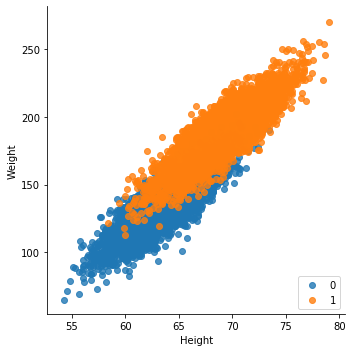

In [3]:
X = np.array(df[df.columns[:-1]].values.tolist(), dtype=np.float64)
label = np.array(df[df.columns[-1]].values.tolist())
index = 0
to_split = [X, label, index]
t_split = to_split
tree_depth = 4
epochs = 1000
min_pts = 5
# childs can be 2^tree_depth len of columns + 3 (bias, left and right)
tree = np.zeros((2**tree_depth, len(X[0])+3))
next_free = 0

dviz.DDScatterDFSns(0, 1, df)

C:\Users\subash\Anaconda3\envs\thesis\lib\site-packages\ipykernel_launcher.py:46: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
C:\Users\subash\Anaconda3\envs\thesis\lib\site-packages\ipykernel_launcher.py:47: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
C:\Users\subash\Anaconda3\envs\thesis\lib\site-packages\ipykernel_launcher.py:64: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`

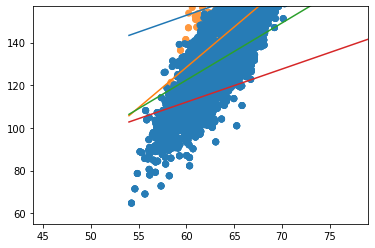

In [4]:
#to_split = df

for depth in range(tree_depth):
    tmp_split = []
    
    # shfuffling for each node
    #to_split = shuffle(to_split)
    
    if len(to_split) != 0:        
            
        X2 = to_split[0]
        label2 = to_split[1]
        #X2, label2, pos, neg = dp.data_giver(to_split)
        pos, neg = dp.pos_neg_giver(to_split)

        # best_gain; highest the information gain will be good
        best_gain = 0
        # best_theta = coefficient or line
        best_theta = []
        # best_pos_side, best_neg_side = data points for pos and negative after the best_gain split
        best_pos_side = []
        best_neg_side = []

        for epoch in range(epochs):
            # find random feature points as linear combination
            p = random.choice(pos)
            n = random.choice(neg)

            # getting parameters from split
            gain, pos_side, neg_side, theta = ds.split_data(X2, label2, pos, neg, p, n)
            #print(gain)

            # checking for best gain and setting rest parameters of it
            if gain > best_gain:
                best_gain = gain
                best_pos_side = pos_side
                best_neg_side = neg_side
                best_theta = theta
                
                #dviz.viz_data_with_line(best_theta, to_split)
            #dviz.viz_data_with_line(best_theta, to_split)

        # building tree
        if depth != tree_depth:
            # check left node's purity
            pos_idx = np.where(label2[[best_pos_side]] == 1)
            neg_idx = np.where(label2[[best_pos_side]] == 0)

            if len(pos_idx) == 0 or len(neg_idx) == 0:
                print("pure node found in left\n")
            else:
                if len(pos_idx[0]) > min_pts and len(neg_idx[0]) > min_pts:

                    # making sub dataframe for left
                    left_x = X2[best_pos_side]
                    left_label = label2[best_pos_side]
                    next_free += 1
                    
                    tree[to_split[2]][3] = next_free
                    tmp_split = [left_x, left_label, next_free]
                    #tmp_split = pd_concat(left_x, left_label)

            # check right node's purity
            pos_idx = np.where(label2[[best_neg_side]] == 1)
            neg_idx = np.where(label2[[best_neg_side]] == 0)

            if len(pos_idx) == 0 or len(neg_idx) == 0:
                print("pure node found in right\n")
            else:
                if len(pos_idx[0]) > min_pts and len(neg_idx[0]) > min_pts:

                    # making sub dataframe for left
                    right_x = X2[best_neg_side]
                    right_label = label2[best_neg_side]                    
                    next_free += 1
                    
                    
                    tree[to_split[2]][4] = next_free
                    
                    tmp_split = [right_x, right_label, next_free]
                    #tmp_split = pd_concat(right_x, right_label)
            
            # for storing weights and +1 for bias
            tree[to_split[2]][:len(X[0])+1] = best_theta.T
                         
        # ploting graph
        
        dviz.viz_data_with_line_np(best_theta, to_split)        
        
    #dviz.viz_data_with_line(best_theta, to_split)
    to_split = tmp_split        
    

In [5]:
tree[:4]

array([[ -0.84340501,   0.53727831, -31.49398841,   1.        ,
          2.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ],
       [ -0.96683932,   0.25538546,  25.21468496,   3.        ,
          4.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ]])

In [6]:
print(pred.predict(tree, X[7]))

y_pred = pred.predict(tree, X)
print(classification_report(label, y_pred, labels=[0, 1]))
print(accuracy_score(label, y_pred))
print(confusion_matrix(label, y_pred))

1
              precision    recall  f1-score   support

           0       1.00      0.12      0.22      5000
           1       0.53      1.00      0.70      5000

    accuracy                           0.56     10000
   macro avg       0.77      0.56      0.46     10000
weighted avg       0.77      0.56      0.46     10000

0.5622
[[ 622 4378]
 [   0 5000]]


In [7]:
#dviz.scatter_plot(to_split)

In [ ]:
multiple feature look working lets see how to it works with other binary larger dataset 


In [ ]:
how to prepare for tree structure 
if l1 >= something or if l1:
    left: pure set of 0 label
    right: if l2 or l2 >= something
        left: l3
            left: 0
            right: 1
        right:
            left: l4
                left/right:0
            right: 0
                

this can be done by analyzing each line creation; use visuals
then prepare for tree before computing or find way to build from tree object
